# ESTIMATING AVERAGE TREATMENT EFFECTS: REGRESSION DISCONTINUITY DESIGNS
Jeff Wooldridge
Michigan State University
BGSE/IZA Course in Microeconometrics
July 2009

http://legacy.iza.org/teaching/wooldridge-course-09/course_html/docs/slides_regdisc_6_r1.pdf

In [1]:
pacman::p_load(wooldridge,stargazer,broom,tidyverse,ggplot2,
               dplyr,tidyr,moderndive,jtools,sjPlot,dotwhisker,FSA,
              car)

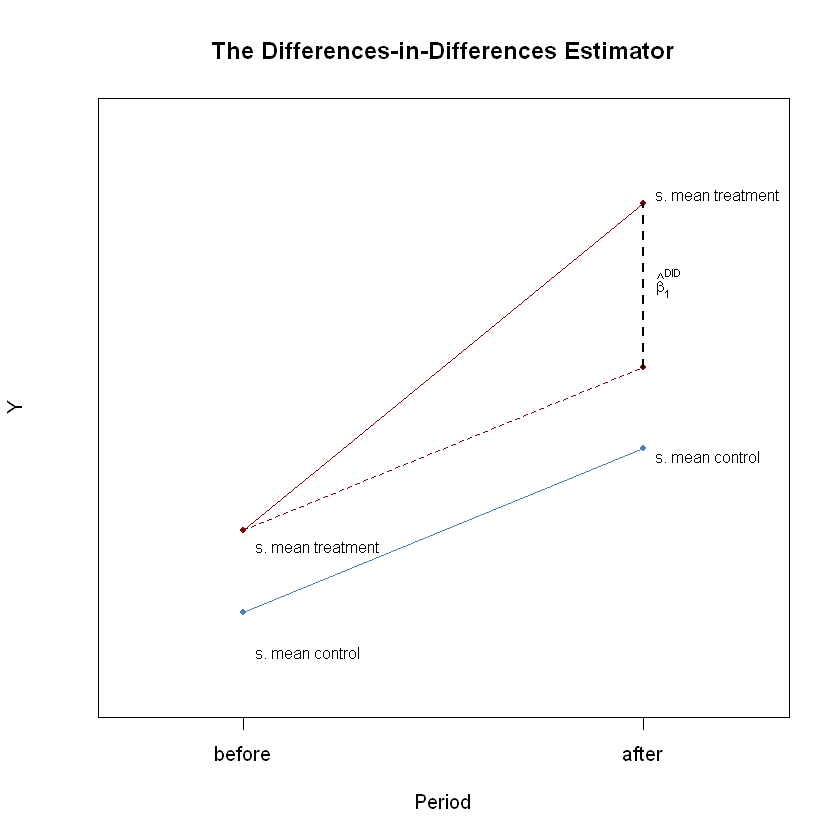

In [1]:
# initialize plot and add control group
plot(c(0, 1), c(6, 8), 
     type = "p",
     ylim = c(5, 12),
     xlim = c(-0.3, 1.3),
     main = "The Differences-in-Differences Estimator",
     xlab = "Period",
     ylab = "Y",
     col = "steelblue",
     pch = 20,
     xaxt = "n",
     yaxt = "n")

axis(1, at = c(0, 1), labels = c("before", "after"))
axis(2, at = c(0, 13))

# add treatment group
points(c(0, 1, 1), c(7, 9, 11), 
       col = "darkred",
       pch = 20)

# add line segments
lines(c(0, 1), c(7, 11), col = "darkred")
lines(c(0, 1), c(6, 8), col = "steelblue")
lines(c(0, 1), c(7, 9), col = "darkred", lty = 2)
lines(c(1, 1), c(9, 11), col = "black", lty = 2, lwd = 2)

# add annotations
text(1, 10, expression(hat(beta)[1]^{DID}), cex = 0.8, pos = 4)
text(0, 5.5, "s. mean control", cex = 0.8 , pos = 4)
text(0, 6.8, "s. mean treatment", cex = 0.8 , pos = 4)
text(1, 7.9, "s. mean control", cex = 0.8 , pos = 4)
text(1, 11.1, "s. mean treatment", cex = 0.8 , pos = 4)

In [2]:
# set sample size
n <- 200

# define treatment effect
TEffect <- 4

# generate treatment dummy
TDummy <- c(rep(0, n/2), rep(1, n/2))

# simulate pre- and post-treatment values of the dependent variable
y_pre <- 7 + rnorm(n)
y_pre[1:n/2] <- y_pre[1:n/2] - 1
y_post <- 7 + 2 + TEffect * TDummy + rnorm(n)
y_post[1:n/2] <- y_post[1:n/2] - 1 

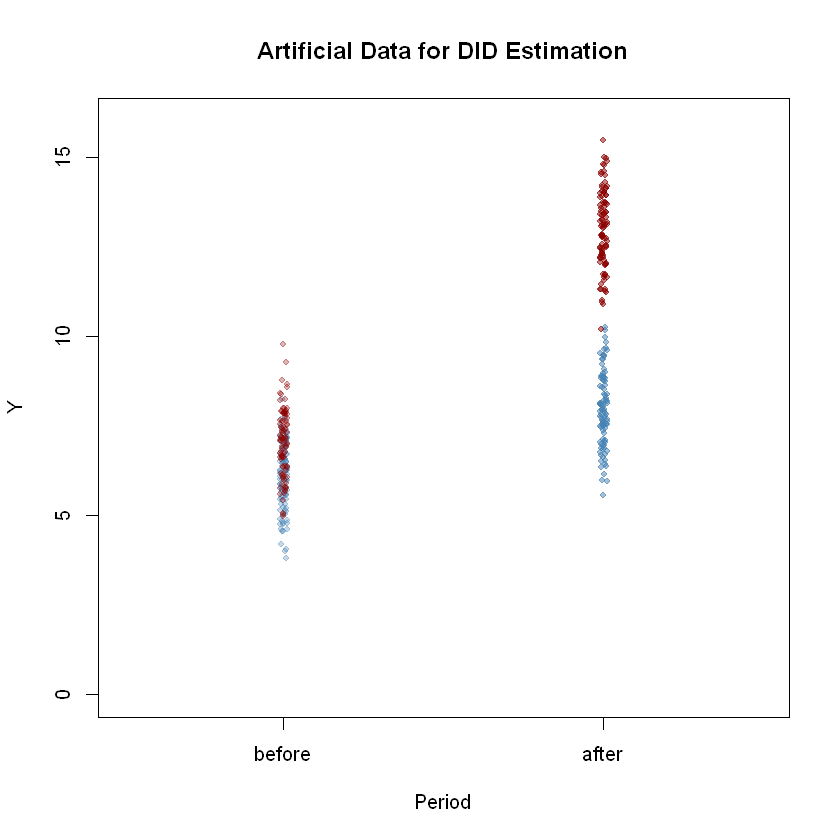

In [3]:
library(scales)

pre <- rep(0, length(y_pre[TDummy==0]))
post <- rep(1, length(y_pre[TDummy==0]))

# plot control group in t=1
plot(jitter(pre, 0.6), 
     y_pre[TDummy == 0], 
     ylim = c(0, 16), 
     col = alpha("steelblue", 0.3),
     pch = 20, 
     xlim = c(-0.5, 1.5),
     ylab = "Y",
     xlab = "Period",
     xaxt = "n",
     main = "Artificial Data for DID Estimation")

axis(1, at = c(0, 1), labels = c("before", "after"))

# add treatment group in t=1
points(jitter(pre, 0.6), 
       y_pre[TDummy == 1], 
       col = alpha("darkred", 0.3), 
       pch = 20)

# add control group in t=2
points(jitter(post, 0.6),
       y_post[TDummy == 0], 
       col = alpha("steelblue", 0.5),
       pch = 20)

# add treatment group in t=2
points(jitter(post, 0.6), 
       y_post[TDummy == 1], 
       col = alpha("darkred", 0.5),
       pch = 20)

In [4]:
# compute the DID estimator for the treatment effect 'by hand'
mean(y_post[TDummy == 1]) - mean(y_pre[TDummy == 1]) - 
(mean(y_post[TDummy == 0]) - mean(y_pre[TDummy == 0]))

[1] 4.072322

In [5]:
# compute the DID estimator using a linear model
lm(I(y_post - y_pre) ~ TDummy)


Call:
lm(formula = I(y_post - y_pre) ~ TDummy)

Coefficients:
(Intercept)       TDummy  
      1.875        4.072  


In [6]:
# prepare data for DID regression using the interaction term 
d <- data.frame("Y" = c(y_pre,y_post),
                "Treatment" = TDummy, 
                "Period" = c(rep("1", n), rep("2", n)))

# estimate the model
lm(Y ~ Treatment * Period, data = d)


Call:
lm(formula = Y ~ Treatment * Period, data = d)

Coefficients:
      (Intercept)          Treatment            Period2  Treatment:Period2  
           6.0659             0.9661             1.8751             4.0723  


Difference in Differences

http://davidcard.berkeley.edu/data_sets.html

https://www.r-bloggers.com/fast-food-causality-and-r-packages-part-2/

public.csv is the data. It does not contain any column names:


In [ ]:
download.file("http://davidcard.berkeley.edu/data_sets/njmin.zip","njmin.zip")

unzip("njmin.zip")

tempfile_path <- tempfile()

download.file("http://davidcard.berkeley.edu/data_sets/njmin.zip", destfile = tempfile_path)

tempdir_path <- tempdir()

unzip(tempfile_path, exdir = tempdir_path)

codebook <- read_lines(file = paste0(tempdir_path, "/codebook"))

variable_names <- codebook %>%
    `[`(8:59) %>%
    `[`(-c(5, 6, 13, 14, 32, 33)) %>%
    str_sub(1, 13) %>%
    str_squish() %>%
    str_to_lower()


dataset <- read_table2(paste0(tempdir_path, "/public.dat"),
                      col_names = FALSE)

dataset <- dataset %>%
    select(-X47) %>%
    `colnames<-`(., variable_names) %>%
    mutate_all(as.numeric) %>%
    mutate(sheet = as.character(sheet))

In [ ]:
dataset <- dataset %>%
    mutate(chain = case_when(chain == 1 ~ "bk",
                             chain == 2 ~ "kfc",
                             chain == 3 ~ "roys",
                             chain == 4 ~ "wendys")) %>%
    mutate(state = case_when(state == 1 ~ "New Jersey",
                             state == 0 ~ "Pennsylvania")) %>%
    mutate(region = case_when(southj == 1 ~ "southj",
              centralj == 1 ~ "centralj",
              northj == 1 ~ "northj",
              shore == 1 ~ "shorej",
              pa1 == 1 ~ "pa1",
              pa2 == 1 ~ "pa2")) %>%
    mutate(meals = case_when(meals == 0 ~ "None",
                             meals == 1 ~ "Free meals",
                             meals == 2 ~ "Reduced price meals",
                             meals == 3 ~ "Both free and reduced price meals")) %>%
    mutate(meals2 = case_when(meals2 == 0 ~ "None",
                             meals2 == 1 ~ "Free meals",
                             meals2 == 2 ~ "Reduced price meals",
                             meals2 == 3 ~ "Both free and reduced price meals")) %>%
    mutate(status2 = case_when(status2 == 0 ~ "Refused 2nd interview",
                               status2 == 1 ~ "Answered 2nd interview",
                               status2 == 2 ~ "Closed for renovations",
                               status2 == 3 ~ "Closed permanently",
                               status2 == 4 ~ "Closed for highway construction",
                               status2 == 5 ~ "Closed due to Mall fire")) %>%
    mutate(co_owned = if_else(co_owned == 1, "Yes", "No")) %>%
    mutate(bonus = if_else(bonus == 1, "Yes", "No")) %>%
    mutate(special2 = if_else(special2 == 1, "Yes", "No")) %>%
    mutate(type2 = if_else(type2 == 1, "Phone", "Personal")) %>%
    select(sheet, chain, co_owned, state, region, everything()) %>%
    select(-southj, -centralj, -northj, -shore, -pa1, -pa2) %>%
    mutate(date2 = lubridate::mdy(date2)) %>%
    rename(open2 = open2r) %>%
    rename(firstinc2 = firstin2)

dataset1 <- dataset %>%
    select(-ends_with("2"), -sheet, -chain, -co_owned, -state, -region, -bonus) %>%
    mutate(type = NA_character_,
           status = NA_character_,
           date = NA)

dataset2 <- dataset %>%
    select(ends_with("2")) %>%
    #mutate(bonus = NA_character_) %>%
    rename_all(~str_remove(., "2"))

other_cols <- dataset %>%
    select(sheet, chain, co_owned, state, region, bonus)

other_cols_1 <- other_cols %>%
    mutate(observation = "February 1992")

other_cols_2 <- other_cols %>%
    mutate(observation = "November 1992")

dataset1 <- bind_cols(other_cols_1, dataset1)
dataset2 <- bind_cols(other_cols_2, dataset2)

njmin <- bind_rows(dataset1, dataset2) %>%
    select(sheet, chain, state, region, observation, everything())

In [ ]:
njmin = readr::read_csv("njmin.csv")

In [ ]:
ggplot(njmin, aes(wage_st)) + geom_density(aes(fill = state), alpha = 0.3) +
    facet_wrap(vars(observation)) + #theme_blog() +
    theme(legend.title = element_blank(), plot.caption = element_text(colour = "white")) +
    labs(title = "Distribution of starting wage rates in fast food restaurants",
         caption = "On April 1st, 1992, New Jersey's minimum wage rose from $4.25 to $5.05. Source: Card and Krueger (1994)")

In [ ]:
summary.means <- njmin                   %>%
                mutate(STATE = dplyr::recode(STATE, `0` = 'PA (control)',
                `1` = 'NJ (treatment)')) %>%
                group_by(STATE, Period) %>%
                summarise_all(
                     funs(
                         mean(., na.rm = TRUE),
                         semean(., na.rm = TRUE)
                     ))

difftable = data.table::dcast(setDT(summary.means),
            STATE ~ Period, value.var = c('mean','semean'))
difftable[, diff:=mean_FTE2 - mean_FTE]
knitr::kable(difftable)

In [ ]:
require(dplyr)
require(ggplot2)
#------------------------------------------------------
#DiD Example 4 - replicate Card and Krueger's 1994
#  minimum wage study
 
#read in data provided by Guido Imbens...note that in Card and Krueger's original
# study they define full time equivilent employees to be full time employees +
# managers + 0.5 * part-time employees
 
#in the data set the following columns are combined to create the variable
# full time equivilent employees:
 
# empft - the number of full time employees before the wage increase
# emptf2 - the number of full time employees after the wage increase
# emppt - the number of part time employees before the wage increase
# emppt2 - the number of part time employees after the wage increase
# nmgrs - the number of managers before the wage increase
# nmgrs2 - the number of managers after the wage increase
 
njmin = tbl_df(read.csv("/Users/aaronmamula/Documents/R projects/njmin.csv")) %>%
  mutate(delta=(empft2+emppt2) - (empft+emppt),fte=nmgrs+empft+(0.5*emppt),
         fte2=nmgrs2+empft2+(0.5*emppt2))
 
#quick calculation of means to make sure our data line up with whats in
# the paper
njmin %>% group_by(state) %>% summarise(mean_fte=mean(fte,na.rm=T),
                                      mean_ft2=mean(fte2,na.rm=T))
#we can compare these numbers to Table 2 from Card and Krueger (1994) and
# confirm that we are working with the same data
#-------------------------------------------------------
 
#------------------------------------------------------
# set up the data for DiD estimation, not completely necessary
# but I'm used to the dplyr/ggplot environment that prefers data
# in long format
est.df = tbl_df(rbind(data.frame(sheet=njmin$sheet,chain=njmin$chain,
                                  state=njmin$state,emp=njmin$fte,t=0),
                 data.frame(sheet=njmin$sheet,chain=njmin$chain,
                            state=njmin$state,emp=njmin$fte2,t=1)))
 
#here state=0 is PA and state=1 is NJ; we set t = 0,1 so we can interact these
# directly to get the DiD coefficient...using the OLS estimator with lm()
# gives up the DiD estimate
summary(lm(emp~factor(state) + factor(t) + (state:t),data=est.df))
#------------------------------------------------------

## Regression Discontinuity Estimators

$$\begin{align}
  Y_i =& \beta_0 + \beta_1 X_i + \beta_2 W_i + u_i \tag{13.12}
\end{align}
$$


$$\begin{align*}
X_i =& 
  \begin{cases}
    1, & W_i \geq c \\
    0, & W_i < c
  \end{cases}
\end{align*}$$





In [7]:
# generate some sample data
W <- runif(1000, -1, 1)
y <- 3 + 2 * W + 10 * (W>=0) + rnorm(1000)

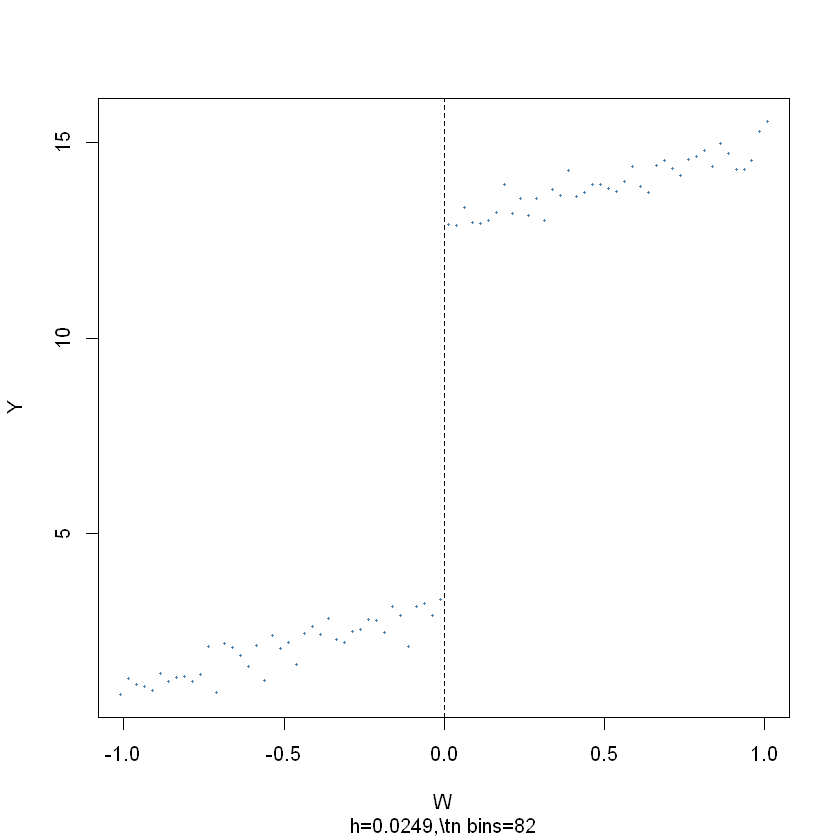

In [11]:
# load the package 'rddtools'
# install.packages("rddtools")
library(rddtools)

# construct rdd_data 
data <- rdd_data(y, W, cutpoint = 0)

# plot the sample data
plot(data,
     col = "steelblue",
     cex = 0.35, 
     xlab = "W", 
     ylab = "Y")

The argument nbins sets the number of bins the running variable is divided into for aggregation. The dots represent bin averages of the outcome variable.

We may use the function rdd_reg_lm() to estimate the treatment effect using model (13.12) for the artificial data generated above. By choosing slope = “same” we restrict the slopes of the estimated regression function to be the same on both sides of the jump at the cutpoint  
W
=
0
 .

In [12]:
# estimate the sharp RDD model
rdd_mod <- rdd_reg_lm(rdd_object = data, 
                      slope = "same")
summary(rdd_mod)


Call:
lm(formula = y ~ ., data = dat_step1, weights = weights)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7820 -0.6237  0.0587  0.6313  2.8535 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.10113    0.06745   45.98   <2e-16 ***
D            9.80102    0.12222   80.19   <2e-16 ***
x            2.04728    0.10583   19.34   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9766 on 997 degrees of freedom
Multiple R-squared:  0.9738,	Adjusted R-squared:  0.9738 
F-statistic: 1.856e+04 on 2 and 997 DF,  p-value: < 2.2e-16


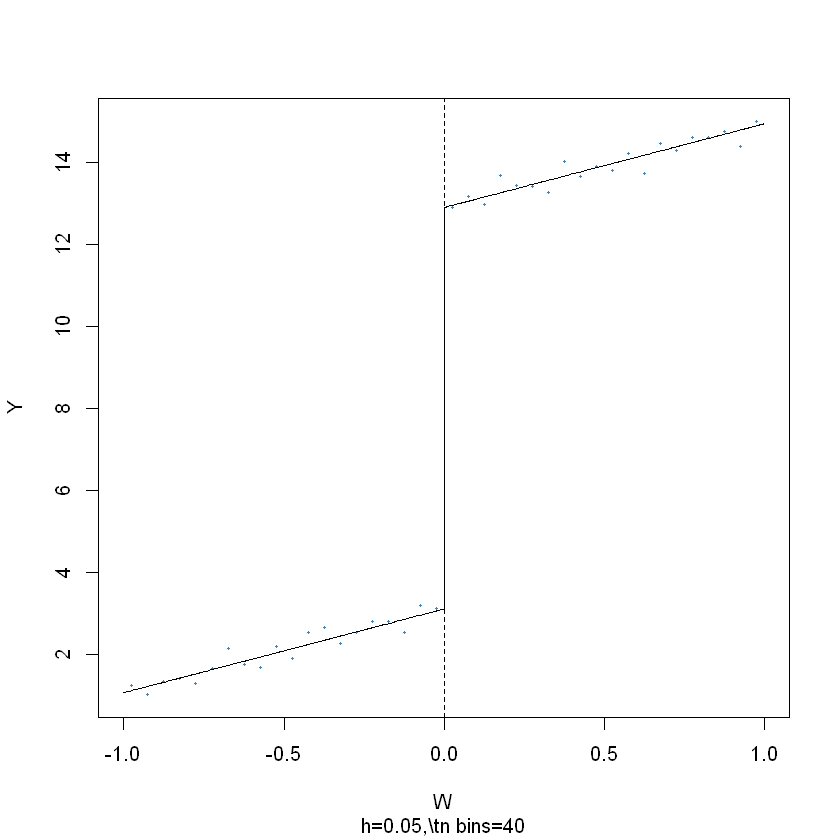

In [13]:
# plot the RDD model along with binned observations
plot(rdd_mod,
     cex = 0.35, 
     col = "steelblue", 
     xlab = "W", 
     ylab = "Y")

When crossing the threshold  
c
  is not the only cause for receipt of the treatment, treatment is not a deterministic function of  
W
i
 . Instead, it is useful to think of  
c
  as a threshold where the probability of receiving the treatment jumps.

This jump may be due to unobservable variables that have impact on the probability of being treated. Thus,  
X
i
  in (13.12) will be correlated with the error  
u
i
 and it becomes more difficult to consistently estimate the treatment effect. In this setting, using a fuzzy regression discontinuity design which is based an IV approach may be a remedy: take the binary variable  
Z
i
  as an indicator for crossing of the threshold,

In [14]:
library(MASS)

# generate sample data
mu <- c(0, 0)
sigma <- matrix(c(1, 0.7, 0.7, 1), ncol = 2)

set.seed(1234)
d <- as.data.frame(mvrnorm(2000, mu, sigma))
colnames(d) <- c("W", "Y")

# introduce fuzziness
d$treatProb <- ifelse(d$W < 0, 0, 0.8)

fuzz <- sapply(X = d$treatProb, FUN = function(x) rbinom(1, 1, prob = x))

# treatment effect
d$Y <- d$Y + fuzz * 2

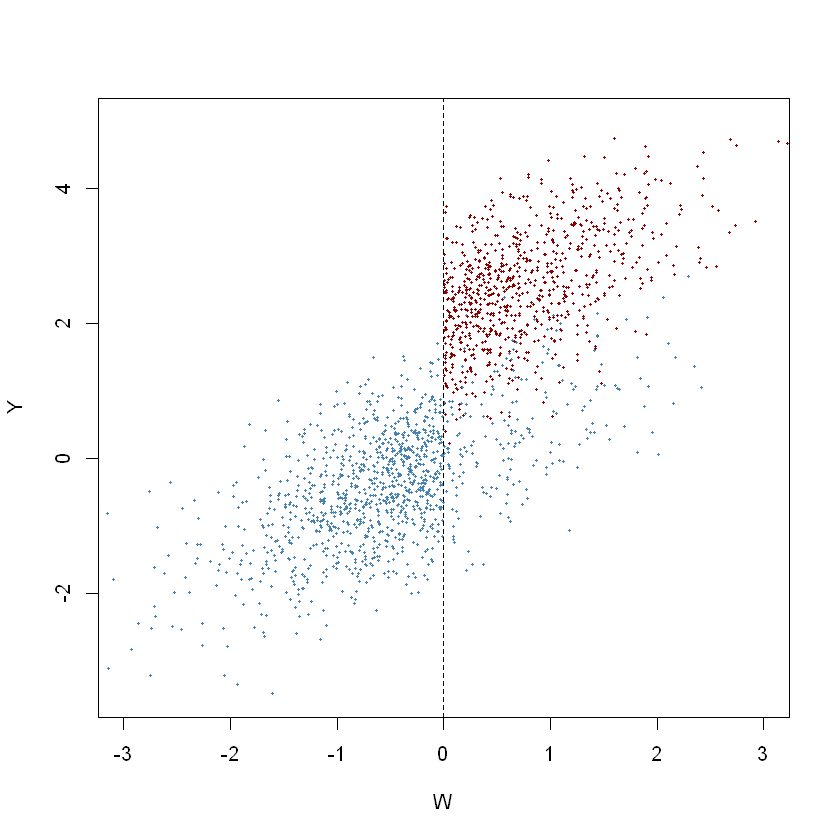

In [15]:
# generate a colored plot of treatment and control group
plot(d$W, d$Y,
     col = c("steelblue", "darkred")[factor(fuzz)], 
     pch= 20, 
     cex = 0.5,
     xlim = c(-3, 3),
     ylim = c(-3.5, 5),
     xlab = "W",
     ylab = "Y")

# add a dashed vertical line at cutoff
abline(v = 0, lty = 2)

Obviously, receipt of treatment is no longer a deterministic function of the running variable  
W
 . Some observations with  
W
≥
0
  did not receive the treatment. We may estimate a FRDD by additionally setting treatProb as the assignment variable z in rdd_data(). Then rdd_reg_lm() applies the following TSLS procedure: treatment is predicted using  
W
i
  and the cutoff dummy  
Z
i
 , the instrumental variable, in the first stage regression. The fitted values from the first stage regression are used to obtain a consistent estimate of the treatment effect using the second stage where the outcome  
Y
  is regressed on the fitted values and the running variable  
W
 .

In [16]:
# estimate the Fuzzy RDD
data <- rdd_data(d$Y, d$W, 
                 cutpoint = 0, 
                 z = d$treatProb)

frdd_mod <- rdd_reg_lm(rdd_object = data, 
                       slope = "same")
frdd_mod

### RDD regression: parametric ###
	Polynomial order:  1 
	Slopes:  same 
	Number of obs: 2000 (left: 999, right: 1001)

	Coefficient:
  Estimate Std. Error t value  Pr(>|t|)    
D 1.981297   0.084696  23.393 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

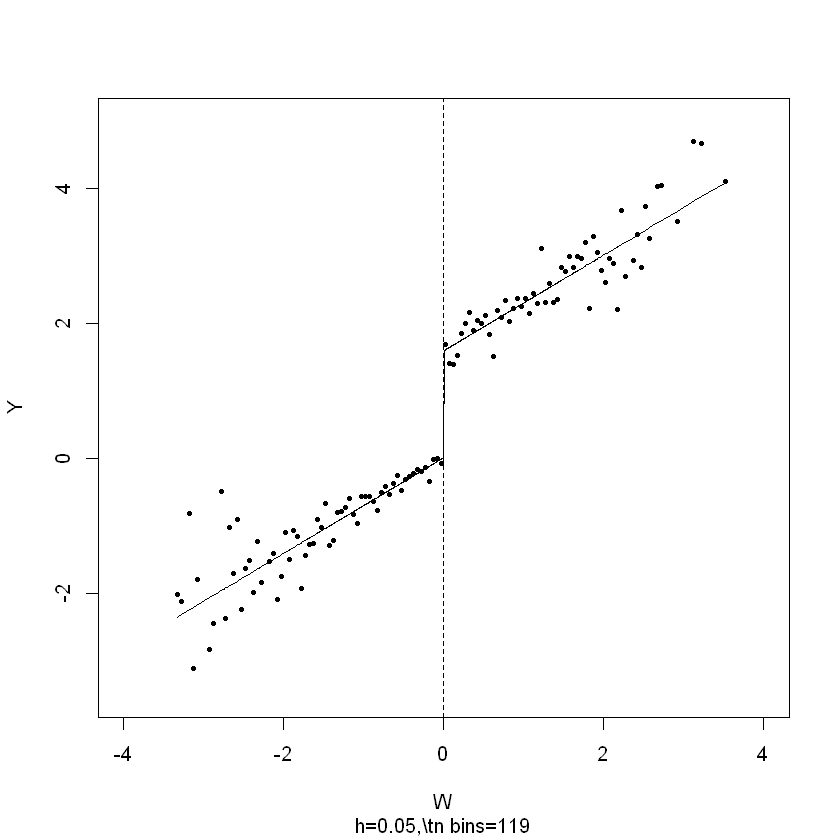

In [17]:
# plot estimated FRDD function
plot(frdd_mod, 
     cex = 0.5, 
     lwd = 0.4,
     xlim = c(-4, 4),
     ylim = c(-3.5, 5),
     xlab = "W",
     ylab = "Y")